### Import modules and constants

In [1]:
import json
import os
import argparse
from collections import Counter
import csv

baseline_packets = {"registered": {"Monday": 11709971, "Tuesday": 11551954, "Wednesday": 13788878, "Thursday": 9322025, "Friday": 9997874}}

### Define the functions that can read the alerts and number of packets redirected from the results

In [2]:
def read_snort_alerts(alert_filepath):
	no_duplicates_data = {}
	data = []
	counter = Counter()
	file = open(alert_filepath)
	if os.path.getsize(alert_filepath) > 0:
		try:
			for line in file.readlines():
				parsed_line = json.loads(line)
				data.append(parsed_line)

				entry_key = str(parsed_line["pkt_num"]) + parsed_line["rule"] + parsed_line["timestamp"]
				if entry_key not in no_duplicates_data:
					no_duplicates_data[entry_key] = line
				
				counter[parsed_line["rule"]]+=1
		except Exception as e:
			print("JSON error: ", e)
	file.close()
	return data, counter, no_duplicates_data

def read_amt_of_cloned_pkts(p4_output_filepath):
	try:
		with open(p4_output_filepath) as file:
			packets_cloned = 0
			get_data = False
			previous_line = ""
			for line in file:
				if "Counter name:  MyEgress.cloned_to_ids" in previous_line and "Index (port):  index: 2" in line:
					get_data = True
				
				if "packet_count" in line and get_data==1:
					packets_cloned += int(line.split()[1])
					get_data = False

				previous_line = line
	except:
		print("No output file in this folder")

	return packets_cloned

### Read baseline alerts

In [3]:
baseline_alerts_folder="../../baseline_alerts/CICIDS2017/alerts_snort3-registered"

def read_baseline(baseline_folder):
	baseline_data = {}
	for alert_file in os.listdir(baseline_folder):
		item_fullpath = os.path.join(baseline_folder, alert_file)

		raw_data, rules_counter, no_duplicates_data =  read_snort_alerts(item_fullpath)
		baseline_data[alert_file.split(".")[0]]={"alerts": no_duplicates_data, "counter": rules_counter}
	
	return baseline_data

baseline_data = read_baseline(baseline_alerts_folder)

### Read the results of one complete experiment: Monday, Tuesday, etc.

In [4]:
def read_experiments_data(experiments_data_folder):
	folder_data = {}
	for item in os.listdir(experiments_data_folder):
		item_fullpath = os.path.join(experiments_data_folder, item)
		if os.path.isfile(item_fullpath):
			continue

		no_duplicates_data = {}
		raw_data = []
		rules_counter = Counter()
		for subdir in os.listdir(item_fullpath):
			if os.path.isfile(os.path.join(item_fullpath, subdir)):
				continue

			alert_file = os.path.join(item_fullpath, subdir) + "/alert_json.txt"
			data, counter, no_duplicates =  read_snort_alerts(alert_file)
			raw_data.extend(data)
			rules_counter.update(counter)
			for key, value in no_duplicates.items():
				if key not in no_duplicates_data:
					no_duplicates_data[key] = value

		packets_cloned = read_amt_of_cloned_pkts(os.path.join(item_fullpath, "output.txt"))
		folder_data[item]={"alerts": no_duplicates_data, "counter": rules_counter, "packets_cloned": packets_cloned}
	return folder_data

### Parse the parameters evaluation experiments

In [28]:
input_folder = "../../../experiments/parameter_evaluation_results"
output_folder = "./"
csv_data = []
for item in os.listdir(input_folder):
    item_fullpath = os.path.join(input_folder, item)
    if os.path.isfile(item_fullpath):
        continue

    folder_name_elements = item.split("_") # 10_10_1024_registered
    experiments_data = read_experiments_data(item_fullpath)

    for key, data in experiments_data.items():
        csv_line = {}

        csv_line["PCAP"] = key
        csv_line["Packets to clone (N)"] = folder_name_elements[0]
        csv_line["Count-min aging time threshold (T)"] = folder_name_elements[1]
        csv_line["Count-min width (W)"] = folder_name_elements[2]
        csv_line["Alerts"] = len(data["alerts"])
        csv_line["% of alerts relative to the baseline"] =  len(data["alerts"])/len(baseline_data[key]["alerts"])
        csv_line["Packets cloned to NIDS"] = data["packets_cloned"]
        csv_line["% of packets cloned to NIDS relative to the baseline"] =  \
                 data["packets_cloned"]/baseline_packets[folder_name_elements[3]][key]
        csv_data.append(csv_line)

keys = csv_data[0].keys()
output_file = output_folder + "/parameters_evaluation.csv"
with open(output_file, 'w') as file:
    w = csv.DictWriter(file, keys)
    w.writeheader()

    for line in csv_data:
        w.writerow(line)

### Importing data mining and plotting libraries

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

parameters_evaluation_df = pd.read_csv("parameters_evaluation.csv", sep=",")
parameters_evaluation_df

,PCAP,Packets to clone (N),Count-min aging time threshold (T),Count-min width (W),Alerts,% of alerts relative to the baseline,Packets cloned to NIDS,% of packets cloned to NIDS relative to the baseline
0,Tuesday,10,10,4096,52165,0.621456,1533750,0.132770
1,Thursday,10,10,4096,54638,0.735618,1472501,0.157959
2,Wednesday,10,10,4096,57368,0.138205,3143596,0.227981
3,Monday,10,10,4096,59710,0.906029,1680407,0.143502
4,Friday,10,10,4096,62235,0.921045,2344608,0.234511
...,...,...,...,...,...,...,...,...
160,Tuesday,25,10,1024,51874,0.617989,1831491,0.158544
161,Thursday,25,10,1024,53982,0.726786,1694111,0.181732
162,Wednesday,25,10,1024,56187,0.135360,3015753,0.218709
163,Monday,25,10,1024,58932,0.894223,1914500,0.163493


### Create the subsets indicating the experiments to plot 
- Exploring different "Count-min width (W)" with the same "Packets to clone (N)"=10 and "Count-min aging time threshold (T)"=10
- Exploring different "Count-min width (W)" with the same "Packets to clone (N)"=10 and "Count-min aging time threshold (T)"=25
- Exploring different "Count-min width (W)" with the same "Packets to clone (N)"=10 and "Count-min aging time threshold (T)"=50
- Exploring different "Packets to clone (N)" with the same "Count-min aging time threshold (T)" and "Count-min width (W)"=1024
- Exploring different "Packets to clone (N)" with the same "Count-min aging time threshold (T)" and "Count-min width (W)"=4096
- Exploring different "Packets to clone (N)" with the same "Count-min aging time threshold (T)" and "Count-min width (W)"=16384

In [30]:
t_10_df = parameters_evaluation_df[(parameters_evaluation_df["Count-min aging time threshold (T)"]==10) & (parameters_evaluation_df["Packets to clone (N)"]==10)]
t_25_df = parameters_evaluation_df[(parameters_evaluation_df["Count-min aging time threshold (T)"]==25) & (parameters_evaluation_df["Packets to clone (N)"]==10)]
t_50_df = parameters_evaluation_df[(parameters_evaluation_df["Count-min aging time threshold (T)"]==50) & (parameters_evaluation_df["Packets to clone (N)"]==10)]
w_1024_df = parameters_evaluation_df[(parameters_evaluation_df["Count-min width (W)"]==1024) & (parameters_evaluation_df["Count-min aging time threshold (T)"]==10)]
w_4096_df = parameters_evaluation_df[(parameters_evaluation_df["Count-min width (W)"]==4096) & (parameters_evaluation_df["Count-min aging time threshold (T)"]==10)]
w_16384_df = parameters_evaluation_df[(parameters_evaluation_df["Count-min width (W)"]==16384) & (parameters_evaluation_df["Count-min aging time threshold (T)"]==10)]

In [31]:
alert_t_10_df = t_10_df[["PCAP", "Count-min width (W)", "% of alerts relative to the baseline"]].pivot_table("% of alerts relative to the baseline", ["Count-min width (W)"], "PCAP")
packets_t_10_df = t_10_df[["PCAP", "Count-min width (W)", "% of packets cloned to NIDS relative to the baseline"]].pivot_table("% of packets cloned to NIDS relative to the baseline", ["Count-min width (W)"], "PCAP")

alert_t_25_df = t_25_df[["PCAP", "Count-min width (W)", "% of alerts relative to the baseline"]].pivot_table("% of alerts relative to the baseline", ["Count-min width (W)"], "PCAP")
packets_t_25_df = t_25_df[["PCAP", "Count-min width (W)", "% of packets cloned to NIDS relative to the baseline"]].pivot_table("% of packets cloned to NIDS relative to the baseline", ["Count-min width (W)"], "PCAP")

alert_t_50_df = t_50_df[["PCAP", "Count-min width (W)", "% of alerts relative to the baseline"]].pivot_table("% of alerts relative to the baseline", ["Count-min width (W)"], "PCAP")
packets_t_50_df = t_50_df[["PCAP", "Count-min width (W)", "% of packets cloned to NIDS relative to the baseline"]].pivot_table("% of packets cloned to NIDS relative to the baseline", ["Count-min width (W)"], "PCAP")

alert_w_1024_df = w_1024_df[["PCAP", "Packets to clone (N)", "% of alerts relative to the baseline"]].pivot_table("% of alerts relative to the baseline", ["Packets to clone (N)"], "PCAP")
packets_w_1024_df = w_1024_df[["PCAP", "Packets to clone (N)", "% of packets cloned to NIDS relative to the baseline"]].pivot_table("% of packets cloned to NIDS relative to the baseline", ["Packets to clone (N)"], "PCAP")

alert_w_4096_df = w_4096_df[["PCAP", "Packets to clone (N)", "% of alerts relative to the baseline"]].pivot_table("% of alerts relative to the baseline", ["Packets to clone (N)"], "PCAP")
packets_w_4096_df = w_4096_df[["PCAP", "Packets to clone (N)", "% of packets cloned to NIDS relative to the baseline"]].pivot_table("% of packets cloned to NIDS relative to the baseline", ["Packets to clone (N)"], "PCAP")

alert_w_16384_df = w_16384_df[["PCAP", "Packets to clone (N)", "% of alerts relative to the baseline"]].pivot_table("% of alerts relative to the baseline", ["Packets to clone (N)"], "PCAP")
packets_w_16384_df = w_16384_df[["PCAP", "Packets to clone (N)", "% of packets cloned to NIDS relative to the baseline"]].pivot_table("% of packets cloned to NIDS relative to the baseline", ["Packets to clone (N)"], "PCAP")

In [32]:
alerts_plot_ylabel = "% of alerts relative to the baseline"
packets_redirected_plot_ylabel = "% of packets cloned to the NIDS\n relative to the baseline"

### Plot dataframe results for N=10 and T=10

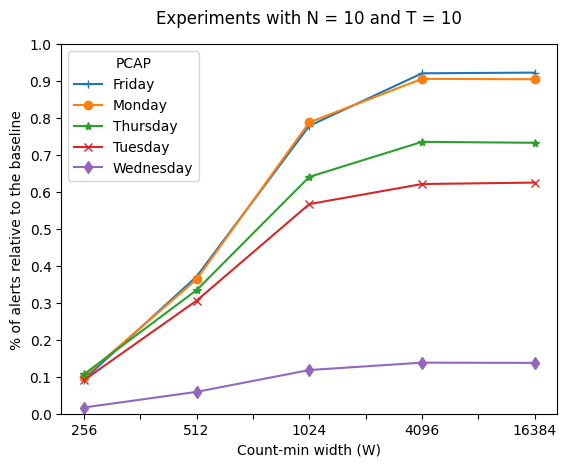

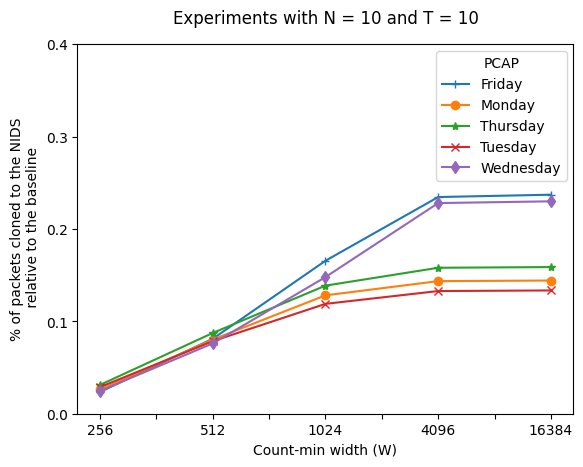

In [39]:
alert_t_10_df.index = alert_t_10_df.index.map(str)
packets_t_10_df.index = packets_t_10_df.index.map(str)

alert_t_10_df.plot(style=['+-', 'o-', '*-', 'x-', 'd-'])
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.ylim(0,1)
plt.ylabel(alerts_plot_ylabel)
plt.title('Experiments with N = 10 and T = 10', pad=15)
plt.savefig('images/Alerts_n_10_t_10.png')
plt.show()

packets_t_10_df.plot(style=['+-', 'o-', '*-', 'x-', 'd-'])
plt.yticks(np.arange(0, 0.5, step=0.1))
plt.ylim(0,0.4)
plt.ylabel(packets_redirected_plot_ylabel)
plt.title('Experiments with N = 10 and T = 10', pad=15)
plt.savefig('images/Packets_redirected_n_10_t_10.png')
plt.show()

### Plot dataframe results for N=10 and T=25

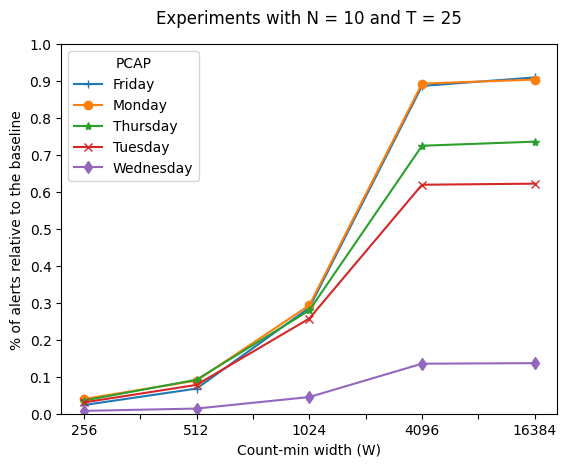

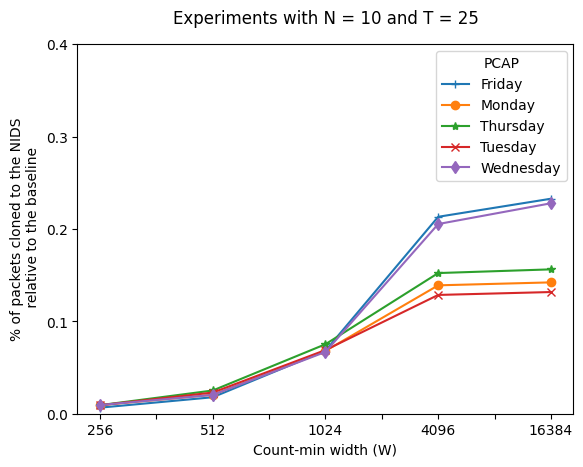

In [40]:
alert_t_25_df.index = alert_t_25_df.index.map(str)
packets_t_25_df.index = packets_t_25_df.index.map(str)

alert_t_25_df.plot(style=['+-', 'o-', '*-', 'x-', 'd-'])
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.ylim(0,1)
plt.ylabel(alerts_plot_ylabel)
plt.title('Experiments with N = 10 and T = 25', pad=15)
plt.savefig('images/Alerts_n_10_t_25.png')
plt.show()

packets_t_25_df.plot(style=['+-', 'o-', '*-', 'x-', 'd-'])
plt.yticks(np.arange(0, 0.5, step=0.1))
plt.ylim(0,0.4)
plt.ylabel(packets_redirected_plot_ylabel)
plt.title('Experiments with N = 10 and T = 25', pad=15)
plt.savefig('images/Packets_cloned_n_10_t_25.png')
plt.show()

### Plot dataframe results for N=10 and T=50

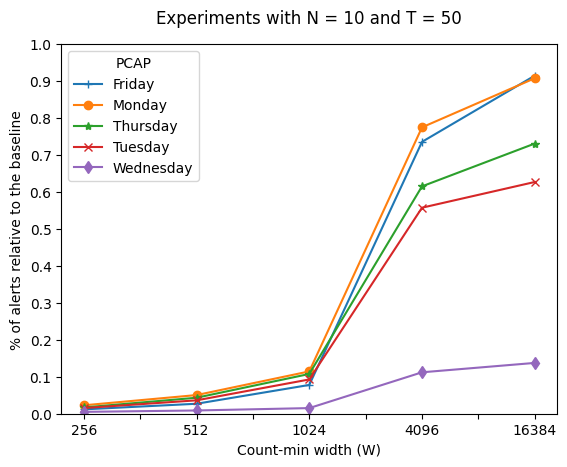

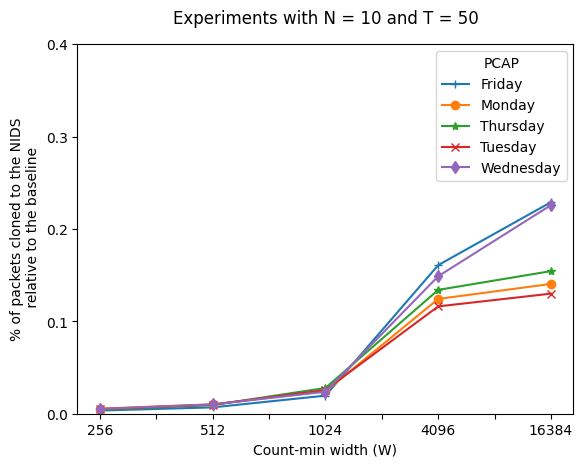

In [41]:
alert_t_50_df.index = alert_t_50_df.index.map(str)
packets_t_50_df.index = packets_t_50_df.index.map(str)

alert_t_50_df.plot(style=['+-', 'o-', '*-', 'x-', 'd-'])
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.ylim(0,1)
plt.ylabel(alerts_plot_ylabel)
plt.title('Experiments with N = 10 and T = 50', pad=15)
plt.savefig('images/Alerts_n_10_t_50.png')
plt.show()

packets_t_50_df.plot(style=['+-', 'o-', '*-', 'x-', 'd-'])
plt.yticks(np.arange(0, 0.5, step=0.1))
plt.ylim(0,0.4)
plt.ylabel(packets_redirected_plot_ylabel)
plt.title('Experiments with N = 10 and T = 50', pad=15)
plt.savefig('images/Packets_cloned_n_10_t_50.png')
plt.show()

### Plot dataframe results for T=10 and W=1024

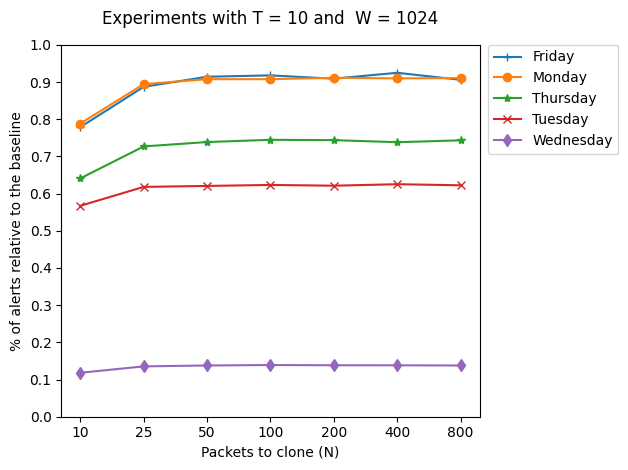

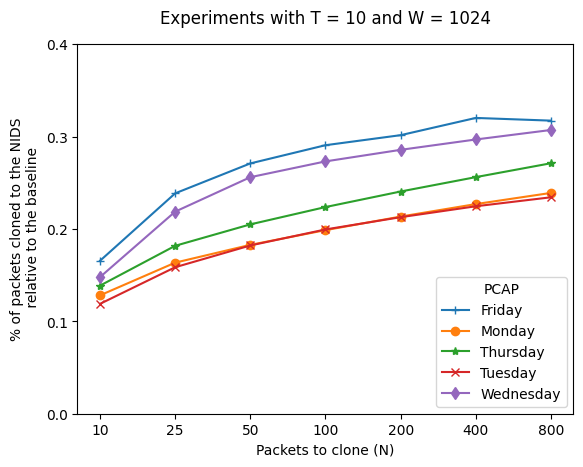

In [42]:
alert_w_1024_df.index = alert_w_1024_df.index.map(str)
packets_w_1024_df.index = packets_w_1024_df.index.map(str)

alert_w_1024_df.plot(style=['+-', 'o-', '*-', 'x-', 'd-'])
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left', borderaxespad=0)
plt.ylabel(alerts_plot_ylabel)
plt.title('Experiments with T = 10 and  W = 1024', pad=15)
plt.tight_layout()
plt.savefig('images/Alerts_t_10_w_1024.png')
plt.show()

packets_w_1024_df.plot(style=['+-', 'o-', '*-', 'x-', 'd-'])
plt.yticks(np.arange(0, 0.5, step=0.1))
plt.ylim(0,0.4)
plt.ylabel(packets_redirected_plot_ylabel)
plt.title('Experiments with T = 10 and W = 1024', pad=15)
plt.savefig('images/Packets_cloned_t_10_w_1024.png')
plt.show()

### Plot dataframe results for T=10 and W=4096

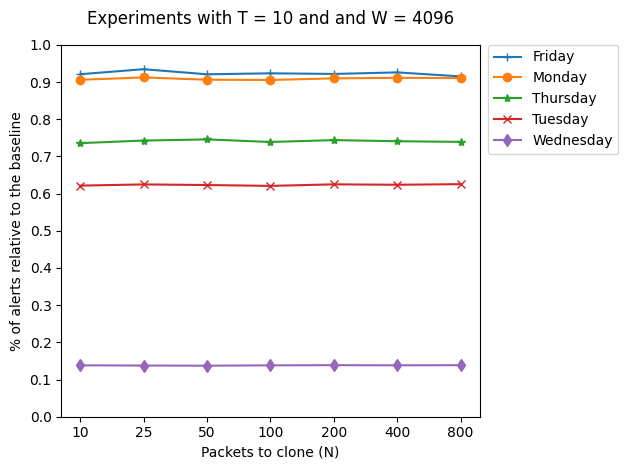

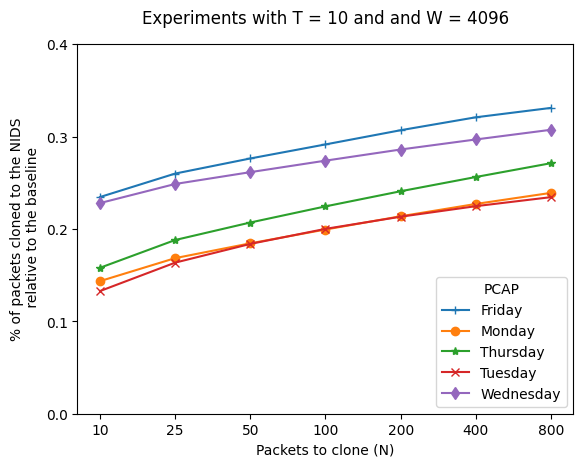

In [43]:
alert_w_4096_df.index = alert_w_4096_df.index.map(str)
packets_w_4096_df.index = packets_w_4096_df.index.map(str)

alert_w_4096_df.plot(style=['+-', 'o-', '*-', 'x-', 'd-'])
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left', borderaxespad=0)
plt.ylabel(alerts_plot_ylabel)
plt.title('Experiments with T = 10 and and W = 4096', pad=15)
plt.tight_layout()
plt.savefig('images/Alerts_t_10_w_4096.png')
plt.show()

packets_w_4096_df.plot(style=['+-', 'o-', '*-', 'x-', 'd-'])
plt.yticks(np.arange(0, 0.5, step=0.1))
plt.ylim(0,0.4)
plt.ylabel(packets_redirected_plot_ylabel)
plt.title('Experiments with T = 10 and and W = 4096', pad=15)
plt.savefig('images/Packets_cloned_t_10_w_4096.png')
plt.show()

### Plot dataframe results for T=10 and W=4096

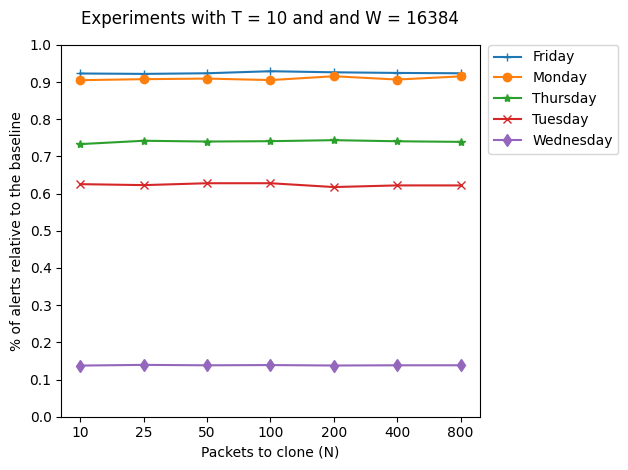

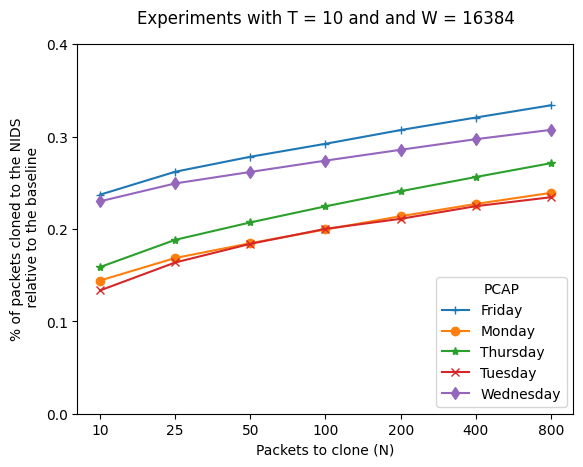

In [44]:
alert_w_16384_df.index = alert_w_16384_df.index.map(str)
packets_w_16384_df.index = packets_w_16384_df.index.map(str)

alert_w_16384_df.plot(style=['+-', 'o-', '*-', 'x-', 'd-'])
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1.02,1), loc='upper left', borderaxespad=0)
plt.ylabel(alerts_plot_ylabel)
plt.title('Experiments with T = 10 and and W = 16384', pad=15)
plt.tight_layout()
plt.savefig('images/Alerts_t_10_w_16384.png')
plt.show()

packets_w_16384_df.plot(style=['+-', 'o-', '*-', 'x-', 'd-'])
plt.yticks(np.arange(0, 0.5, step=0.1))
plt.ylim(0,0.4)
plt.ylabel(packets_redirected_plot_ylabel)
plt.title('Experiments with T = 10 and and W = 16384', pad=15)
plt.savefig('images/Packets_cloned_t_10_w_16384.png')
plt.show()